In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import torch
from torch.utils.data import DataLoader
from torchsummary import summary
from tqdm import tqdm
from nanopore_dataset import create_sample_map
from nanopore_dataset import create_splits
from nanopore_dataset import load_csv
from nanopore_dataset import NanoporeDataset

from resnet1d import ResNet1D
import seaborn as sns

In [4]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"

In [5]:
model = ResNet1D(
            in_channels=1,
            base_filters=128,
            kernel_size=3,
            stride=2,
            groups=1,
            n_block=8,
            n_classes=2,
            downsample_gap=2,
            increasefilter_gap=4,
            use_do=False)

summary(model, (1, 400), device= device)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv1d-1             [-1, 128, 400]             512
   MyConv1dPadSame-2             [-1, 128, 400]               0
       BatchNorm1d-3             [-1, 128, 400]             256
              ReLU-4             [-1, 128, 400]               0
            Conv1d-5             [-1, 128, 400]          49,280
   MyConv1dPadSame-6             [-1, 128, 400]               0
       BatchNorm1d-7             [-1, 128, 400]             256
              ReLU-8             [-1, 128, 400]               0
            Conv1d-9             [-1, 128, 400]          49,280
  MyConv1dPadSame-10             [-1, 128, 400]               0
       BasicBlock-11             [-1, 128, 400]               0
      BatchNorm1d-12             [-1, 128, 400]             256
             ReLU-13             [-1, 128, 400]               0
           Conv1d-14             [-1, 1

In [6]:
MESMLR_FN = './nanopore_classification/best_models/mesmlr_resnet1d.pt'
ADDSEQ_FN = './nanopore_classification/best_models/addseq_resnet1d.pt'

weights_path = ADDSEQ_FN
model.load_state_dict(torch.load(weights_path, map_location=torch.device(device)))
model.to(device)
model.eval()

ResNet1D(
  (first_block_conv): MyConv1dPadSame(
    (conv): Conv1d(1, 128, kernel_size=(3,), stride=(1,))
  )
  (first_block_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (first_block_relu): ReLU()
  (basicblock_list): ModuleList(
    (0): BasicBlock(
      (bn1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU()
      (do1): Dropout(p=0.5, inplace=False)
      (conv1): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      )
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU()
      (do2): Dropout(p=0.5, inplace=False)
      (conv2): MyConv1dPadSame(
        (conv): Conv1d(128, 128, kernel_size=(3,), stride=(1,))
      )
      (max_pool): MyMaxPool1dPadSame(
        (max_pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
      )
    )
    (1): BasicBlock(
      (bn1)

In [9]:
neg_fn = '../data/data/addseq/reprocessed-unique.0.eventalign.signal.csv'
pos_fn = '../data/data/addseq/reprocessed-unique.500.eventalign.signal.csv'

In [10]:
min_val = 50 # Used to clip outliers
max_val = 130 # Used to clip outliers

seq_len = 400

print("Preparing unmodified...")
print("Loading csv...")
unmodified_sequences = load_csv(neg_fn,
                                min_val=min_val,
                                max_val=max_val,
                                max_sequences=None)
print("Creating sample map...")
unmodified_sample_map = create_sample_map(unmodified_sequences,
                                          seq_len=seq_len)

print("Creating splits...")
unmodified_train, unmodified_val, unmodified_test = create_splits(
        unmodified_sequences, unmodified_sample_map, seq_len=seq_len, shuffle=False)
print("Prepared.")

print("Preparing modified...")
print("Loading csv...")
modified_sequences = load_csv(pos_fn,
                              min_val=min_val,
                              max_val=max_val,
                              max_sequences=None)
print("Creating sample map...")
modified_sample_map = create_sample_map(modified_sequences,
                                        seq_len=seq_len)
print("Creating splits...")
modified_train, modified_val, modified_test = create_splits(
        modified_sequences, modified_sample_map, seq_len=seq_len, shuffle=False)
print("Prepared.")

Preparing unmodified...
Loading csv...


87090426it [01:33, 927210.77it/s]


Creating sample map...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 1318/1318 [01:31<00:00, 14.46it/s]


Creating splits...


100%|████████████████████████████████████████████████████████████████████████████| 86107601/86107601 [00:32<00:00, 2609525.03it/s]


Prepared.
Preparing modified...
Loading csv...


89565238it [01:43, 862064.86it/s]


Creating sample map...


100%|█████████████████████████████████████████████████████████████████████████████████████████| 2390/2390 [01:44<00:00, 22.95it/s]


Creating splits...


100%|████████████████████████████████████████████████████████████████████████████| 88556920/88556920 [00:32<00:00, 2747031.21it/s]

Prepared.


In [66]:
batch_size = 5000
val_dataset = NanoporeDataset(unmodified_sequences,
                              unmodified_val,
                              modified_sequences,
                              modified_val,
                              device=device,
                              synthetic=False,
                              seq_len=seq_len)

val_dataloader = DataLoader(val_dataset,
                            batch_size=batch_size,
                            shuffle=False)

In [ ]:
with torch.no_grad():
    seq_preds = {}
    dataloader_idx = 0
    for samples, labels in tqdm(val_dataloader):
        samples.to(device)
        pred = model(samples).sigmoid()
        for i in range(len(pred)):
            seq_idx = val_dataset.get_seq_idx(dataloader_idx)
            dataloader_idx += 1
            seq_label = labels[i].item()
            prediction = pred[i].item()
            seq_id = (seq_label, seq_idx)
            if seq_id not in seq_preds:
                seq_preds[seq_id] = []
            seq_preds[seq_id].append(pred[i].item())
            if seq_label == 1.0:
                pos_read.append(prediction)
            else:
                neg_read.append(prediction)

  8%|██████▌                                                                              | 530/6841 [1:47:24<21:57:02, 12.52s/it]

In [89]:
pos_read = []
neg_read = []

In [90]:
for i in seq_preds.values():
    for pred in i:
        neg_read.append(pred)

In [91]:
len(neg_read)

9075000

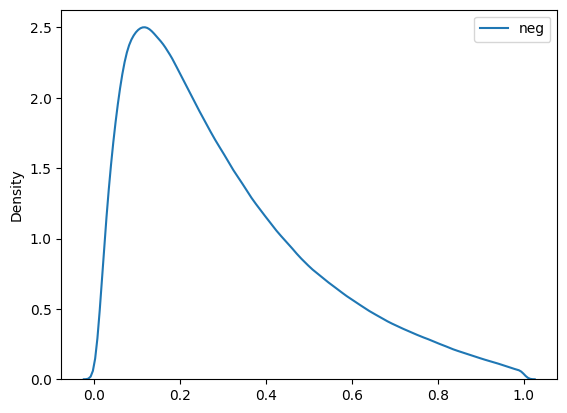

In [93]:
sns.kdeplot(np.array(neg_read), label= 'neg')
sns.kdeplot(np.array(pos_read), label= 'pos')
plt.legend()
plt.savefig('../results/figures/addseq_full_predicted_prob_distribution.pdf')